# Imports and variables

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import load_model
from keras.layers import *
from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences
from keras.layers import *
from keras import backend as K
from keras import layers
import csv
import matplotlib
import os

matplotlib.rcParams['figure.dpi'] = 100

os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
# # For Colab only:
# path_to_project = 'Intents-Classification-in-dialogue/'
# Otherwise,
path_to_project = '../'

column_names = ['c1', 'Utterances', 'Basic', 'General', 'Full']
MAX_PADDING = 100

# Data Import and Preprocessing

In [3]:
def import_data_and_tokenizer(path_to_data):
    #Import data
    full_data = pd.read_csv(path_to_data, delimiter='|', names=column_names)

    #Create tokenizer
    tokenizer = Tokenizer(num_words = 5000, split=" ")
    tokenizer.fit_on_texts(full_data['Utterances'].values)

    return full_data, tokenizer

In [4]:
# We import the full dataset and we display it
full_data, tokenizer = import_data_and_tokenizer(path_to_project + 'Datasets/MRDA/mrda_data/full_set.txt')
full_data.head()

,c1,Utterances,Basic,General,Full
0,fe016,okay.,F,fg,fg
1,fe016,so um,F,fh,fh
2,fe016,i was going to try to get out of here like in ...,S,s,rt
3,fe016,um,F,fh,fh
4,fe016,because i really appreciate people coming.,S,s,s


In [5]:
def processed_data(data):
    """
    This function extracts and processes the input data and returns the x and y values for the model
    """
    data['Utterances'] = data['Utterances'].apply(lambda x: x.lower())
    data['Utterances'] = data['Utterances'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

    # We tokenize the x values
    x = pad_sequences(tokenizer.texts_to_sequences(data['Utterances'].values), padding='post', maxlen=MAX_PADDING)
    # We create dummy variables for the y values (one hot encoding)
    y = pd.get_dummies(data['Basic']).values
    
    return x,y

In [6]:
# We import the train, validation and test datasets
train_data = pd.read_csv(path_to_project + 'Datasets/MRDA/mrda_data/train_set.txt', delimiter='|', names=column_names)
x_train, y_train = processed_data(train_data)

val_data = pd.read_csv(path_to_project + 'Datasets/MRDA/mrda_data/val_set.txt', delimiter='|', names=column_names)
x_val, y_val = processed_data(val_data)

test_data = pd.read_csv(path_to_project + 'Datasets/MRDA/mrda_data/test_set.txt', delimiter='|', names=column_names)
x_test, y_test = processed_data(test_data)

# Model definition and training: Keras Embedding + BiLSTM

In [7]:
# We import a pre-trained model
model = load_model(path_to_project+'embedding_bilstm_1.h5')

Details of the neural network model: **Keras Embedding + BiLSTM**
- Embedding layer with 5000 words and 300 dimensions
- Bidirectional LSTM with 20 units
- Dropout of 0.3
- Recurrent dropout of 0.2
- Dense layer with 5 units and softmax activation

In [8]:
inputs1=Input(shape=(100,))
x1=Embedding(input_dim=5000,
             output_dim=300,
             input_length=100,
             embeddings_regularizer=keras.regularizers.l2(.001))(inputs1)

x1=Bidirectional(LSTM(units=20,
                      dropout=0.3,
                      recurrent_dropout=0.2,
                      return_sequences = False))(x1)

output=Dense(5,activation='softmax')(x1) 
model=keras.Model(inputs1,output)

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          1500000   
                                                                 
 bidirectional (Bidirectiona  (None, 40)               51360     
 l)                                                              
                                                                 
 dense (Dense)               (None, 5)                 205       
                                                                 
Total params: 1,551,565
Trainable params: 1,551,565
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
2346/2346 [==============================] - 825s 349ms/step - loss: 0.7446 - accuracy: 0.7494 - val_loss: 0.7281 - val_accuracy: 0.7544
Epoch 2/100
2346/2346 [==============================] - 815s 347ms/step - loss: 0.6602 - accuracy: 0.7784 - val_loss: 0.7150 - val_accuracy: 0.7608
Epoch 3/100
2346/2346 [==============================] - 833s 355ms/step - loss: 0.6483 - accuracy: 0.7837 - val_loss: 0.7059 - val_accuracy: 0.7650
Epoch 4/100
2346/2346 [==============================] - 843s 359ms/step - loss: 0.6427 - accuracy: 0.7865 - val_loss: 0.7081 - val_accuracy: 0.7681
Epoch 5/100
2346/2346 [==============================] - 816s 348ms/step - loss: 0.6379 - accuracy: 0.7884 - val_loss: 0.7079 - val_accuracy: 0.7633
Epoch 6/100
2346/2346 [==============================] - 822s 350ms/step - loss: 0.6344 - accuracy: 0.7897 - val_loss: 0.6962 - val_accuracy: 0.7660
Epoch 7/100
2346/2346 [==============================] - 818s 349ms/step - loss: 0.6323 - accuracy: 0.7910

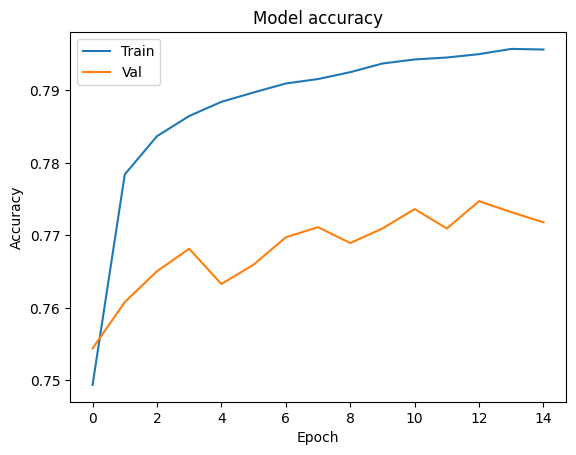

In [10]:
# We define the early stopping callback: the training will stop if the accuracy does not improve after 1 epoch
early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', 
                                               mode='auto', 
                                               patience=1, 
                                               verbose=1)

# We train the model
hist = model.fit(x_train, y_train, 
          epochs=100, 
          batch_size=32, 
          verbose=1,
          callbacks=[early_stopping],
          validation_data=(x_val, y_val))

# We save the trained model
model.save('embedding_bilstm_1.h5')

# We plot the training and validation accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Model evaluation

In [12]:
model.evaluate(x_test, y_test)

522/522 [==============================] - 22s 43ms/step - loss: 0.6536 - accuracy: 0.7790


[0.653554379940033, 0.7790085077285767]

In [13]:
y_pred = model.predict(x_test)

# Convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

522/522 [==============================] - 21s 39ms/step


### F1 score

In [14]:
from sklearn.metrics import f1_score
print("F1 score(macro)",f1_score(y_true_classes, y_pred_classes, average='macro'))
print("F1 score(micro)",f1_score(y_true_classes, y_pred_classes, average='micro'))

F1 score(macro) 0.6938049172338172
F1 score(micro) 0.7790085019758113


### Confusion matrix

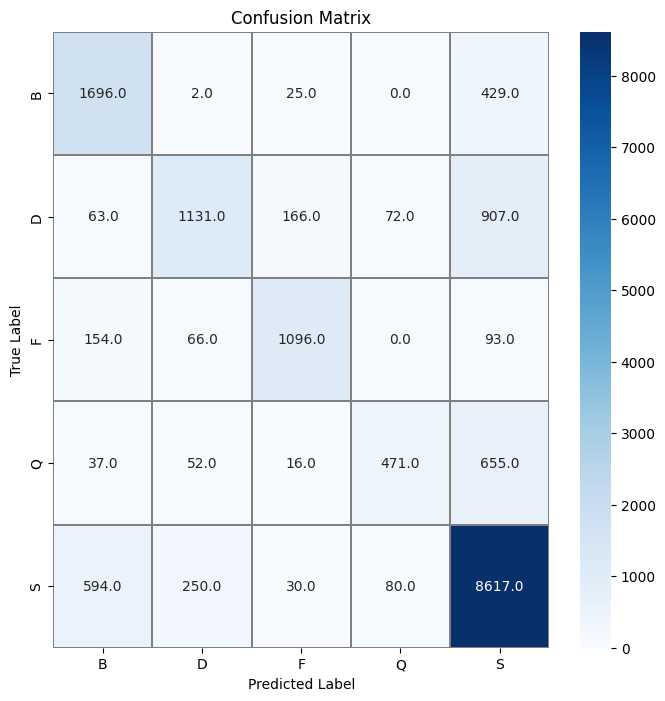

In [15]:
# !pip install numpy==1.22 scipy scikit-learn -U --user
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mtx = confusion_matrix(y_true_classes, y_pred_classes)

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,linecolor="gray", fmt= '.1f',ax=ax,cmap="Blues",yticklabels=['B', 'D', 'F', 'Q', 'S'],xticklabels=['B', 'D', 'F', 'Q', 'S'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Classification report (precision, recall, f1-score, support)

In [16]:
from sklearn.metrics import classification_report
target_names = ['B', 'D', 'F', 'Q', 'S']
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

              precision    recall  f1-score   support

           B       0.67      0.79      0.72      2152
           D       0.75      0.48      0.59      2339
           F       0.82      0.78      0.80      1409
           Q       0.76      0.38      0.51      1231
           S       0.81      0.90      0.85      9571

    accuracy                           0.78     16702
   macro avg       0.76      0.67      0.69     16702
weighted avg       0.78      0.78      0.77     16702



# Model prediction

In [17]:
# Predicting a single new observation

DA = np.array(['B','D','F','Q','S'])
a = ["will you go",
     "Not at all",
     "uh um",
     "I don't know",
     "Do you want to go?"]
tokenizer = Tokenizer(num_words = 5000, split=" ")
full_data = pd.read_csv(path_to_project + 'Datasets/MRDA/mrda_data/full_set.txt', delimiter='|', names=column_names)
tokenizer.fit_on_texts(full_data['Utterances'].values)
a_tokenized = tokenizer.texts_to_sequences(a)
a_tokenized = np.array(a_tokenized)
a_tokenized = pad_sequences(a_tokenized, padding='post', maxlen=100)
prediction = model.predict(np.array(a_tokenized))

prediction_classes = DA[prediction.argmax(1)]

# Print the prediction with the associated class
for i in range(len(a)):
     print("Utterance:", a[i])
     print("Prediction:", prediction[i])
     print("Predicted class:", prediction_classes[i])
     print("")

1/1 [==============================] - 0s 44ms/step
Utterance: will you go
Prediction: [5.0509139e-04 4.6187658e-02 6.1081708e-05 9.1056901e-01 4.2677123e-02]
Predicted class: Q

Utterance: Not at all
Prediction: [2.5168245e-04 1.6454649e-01 7.2304526e-04 3.1615153e-02 8.0286360e-01]
Predicted class: S

Utterance: uh um
Prediction: [5.7037580e-03 4.7777496e-02 9.3801141e-01 2.8657579e-04 8.2207071e-03]
Predicted class: F

Utterance: I don't know
Prediction: [0.00400022 0.01891972 0.03495623 0.00293003 0.9391937 ]
Predicted class: S

Utterance: Do you want to go?
Prediction: [2.5152627e-04 1.2882211e-02 2.3036588e-05 9.4375545e-01 4.3087777e-02]
Predicted class: Q



<ipython-input-17-102df20f187a>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a_tokenized = np.array(a_tokenized)
